## E11 - SPARK

---

This exercise **should be completed using the Azure VM** that you have created
  - Transfer this Notebook (***E11.ipynb***) to the VM
  - Create the solution using the VM
  - After solving the problem transfer the Notebook back to your local computer
  - Upload it to the E11 submission point
  - Do not forget to answer the questions asked in **https://forms.gle/86FH1Ng8Ywdcf16TA** (use your iitb.ac.in credentials)

**Submissions due by: November 26, 23:55 hrs** (strictly no extensions will be given)

Post your queries, if any, to the Moodle forum: [**Queries and Discussions**](https://moodle.iitb.ac.in/mod/forum/view.php?id=75889)

---

### Part-1
#### This section illustrates the use of SPARK Dataframe functions to process nsedata.csv
- Review **Part-1** to understand the code by referring to SPARK documentation.
- Add your comment to each cell, to explain its purpose
- Add code / create additional cells for debugging purpose, and comment them too

### Part-2 **[10 marks]**

  - This part carries 10 marks
    - 5 marks for the correctness and quality of ***properly commented*** code
    - 5 marks for overall correctness of the results
<br><br>
- Using SPARK functions, solve the problem stated in **Part-2**
  - (***DO NOT USE the createTempView function in your solution!***)
  - (***DO NOT USE PANDAS Dataframe in your solution***)

---

### Submission Guidelines
- **Part-1 and Part-2**
  - Upload this Notebook, with your solutio, to the E11 submission point.
    - **BEFORE UPLOADING, ENSURE THAT YOU REMOVE / TRIM LENGTHY DEBUG OUTPUTS**.
    - Short debug outputs of up to 5 lines are acceptable.
- **Part-2 [10 marks]**
  - Answer the questions in the Form: **https://forms.gle/86FH1Ng8Ywdcf16TA**

---


## <b>Part 1</b>

In [ ]:
import findspark
findspark.init()

In [ ]:
import pyspark
from pyspark.sql.types import *
from pyspark.sql import functions as F

In [ ]:
sc = pyspark.SparkContext(appName="E9-2")

In [ ]:
ss = pyspark.sql.SparkSession(sc)

In [ ]:
dfr = ss.read

In [ ]:
schemaStruct = StructType()
schemaStruct.add("SYMBOL", StringType(), True)
schemaStruct.add("SERIES", StringType(), True)
schemaStruct.add("OPEN", DoubleType(), True)
schemaStruct.add("HIGH", DoubleType(), True)
schemaStruct.add("LOW", DoubleType(), True)
schemaStruct.add("CLOSE", DoubleType(), True)
schemaStruct.add("LAST", DoubleType(), True)
schemaStruct.add("PREVCLOSE", DoubleType(), True)
schemaStruct.add("TOTTRDQTY", LongType(), True)
schemaStruct.add("TOTTRDVAL", DoubleType(), True)
schemaStruct.add("TIMESTAMP", StringType(), True)
schemaStruct.add("ADDNL", StringType(), True)


In [ ]:
df = dfr.csv("/home/hduser/spark/nsedata.csv", schema=schemaStruct, header=True)

#### <b>Basics : Using SPARK for analysis</b>

In [ ]:
def create_subset_from_df(company_code):
    tcode = company_code.lower()
    df_subset = df.select(\
                    F.col("OPEN").alias("OPEN_" + tcode),\
                    F.col("HIGH").alias("HIGH_"+ tcode),\
                    F.col("LOW").alias("LOW_"+ tcode),\
                    F.col("CLOSE").alias("CLOSE_" + tcode),\
                    F.col("TIMESTAMP")).\
                    where(F.col("SYMBOL") == company_code)
    return(df_subset)

In [ ]:
# Why do we need to use the alias function, above? What happens if we do not alias / rename the columns?

In [ ]:
df_infy = create_subset_from_df("INFY")
df_infy.show(5)
df_infy.describe().show()

In [ ]:
df_tcs = create_subset_from_df("TCS")
df_tcs.show(5)
df_tcs.describe().show()

In [ ]:
df_join = df_tcs.join(df_infy,"TIMESTAMP").select("TIMESTAMP","CLOSE_tcs","CLOSE_infy")
df_join.show(5)

In [ ]:
df_join.select(F.abs(df_join["CLOSE_tcs"] - df_join["CLOSE_infy"]).alias("PriceDiff")).describe().show()

In [ ]:
df_join.filter(F.abs(df_join["CLOSE_tcs"] - df_join["CLOSE_infy"]) < 180).show()

In [ ]:
from pyspark.sql.functions import col, date_format, to_date

df1 = df.withColumn("TIMESTAMP2", date_format(to_date(col("TIMESTAMP"), "dd-MMM-yyyy"), "yyyy-MM"))

In [ ]:
df1.printSchema()

In [ ]:
df1.show(5)

In [ ]:
from pyspark.sql import functions as F

df_t1 = df1.groupBy("SYMBOL","TIMESTAMP2").agg(F.min("OPEN"), F.max("OPEN"), F.avg("OPEN"),\
                                       F.stddev("OPEN"), F.count("OPEN"))

In [ ]:
df_t1.show(5)

In [ ]:
df_t2 = df_t1.sort(F.asc("SYMBOL"), F.asc("TIMESTAMP2"))

In [ ]:
df_t2.show(5)

In [ ]:
# Uncomment the following statement to generate the output, and analyze it
# Write your observations in the next cell

#df_t2.write.csv("monthly_stats.csv")

In [ ]:
# Your observation related to monthly_stats

---

## Part - 2
###  SPARK Based Stock Analysis and Portfolio Management

---

  - This part ***has*** to be solved using the Azure VM that you have created
  - **This part carries 10 marks**
    - 5 marks for the correctness and quality of ***properly commented*** code
    - 5 marks for overall correctness of the results

---

#### Problem Statement
Based on equity (EQ) data contained in ***nsedata.csv***, you are tasked with the responsibility to identify **5 pairs of stocks** stocks to invest in, based on the strategy and steps outlined below:

You have to process the data for the year 2012, and then make investment decisions for the following year - 2013. Assume that you are doing the analysis and selecting the stocks on Jan 1, 2013. 

1. You are required to draw up an initial list of stocks - ***USE THE FOLLOWING CODE SEGMENT TO CREATE THE INITIAL LIST OF STOCKS***

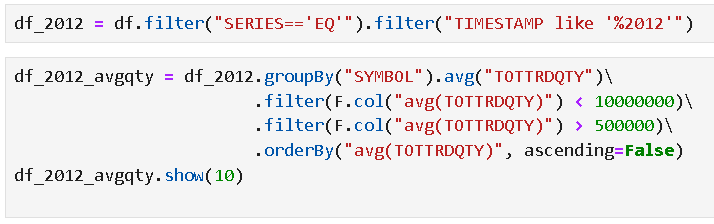

**How many stocks are there in your list at this stage?**

2. From among these stocks you have to then select stocks that have shown maximum overall growth between 1/1/2012 and 31/12/2012 (or the nearest trading days). The hope is that they will continue to grow in the future.
    1. How many stocks are there in your list at this stage, that is, after dropping stocks that have NOT shown positive growth?
1. You should ensure that volatility and negative market movements will not adversely affect your total investment, substantially.
    - One way to achieve this involves selecting ***stock pairs that are negatively correlated***, so that if one stock loses value its partner will most likely gain value - thereby reducing the overall negative impact on the portfolio. As all these stocks are high growth stocks, anyway, the expectation is that the portfolio witll grow, overall. **Note: It is possible for certain stocks to be part of multiple pairs**.
    - The next step, therefore, is to create pairwise correlation coefficient data between all the stocks in the list at this stage (stocks that are liquid, and shown growth in 2012)
    - Sort the stock pairs in ***ascending*** values of their correlation coefficients, so that the ***most negative correlation values are at the top***
    1. Which are the first 5 pairs in this list? Select them.
1. Purchase 1 unit of each of these stock pairs on the first trading day of 2013. If some stocks are part of multiple pairs ***purchase 1 unit for each presence***.
    1. What is the total value of your investment? 
1. After you have selected the 5 pairs and made the above investments on 1-Jan-2013, you should assess the situation on 31/12/2013.
    1. What is the total value of your investment on 31/12/2013
    1. By how much has the portfolio value changed? This can be positive or negative
    1. What is the percentage change in the portfolio value? 
    1. The price of which stocks in your portfolio have increased?
    1. The price of which stocks in your portfolio have decreased?
1. Comparatively, how did the market perform during the same period? This can be assessed as follows:
    1. Considering the period 1/1/2012 - 31/12/2012 create a list of top 25 highly traded stocks with high ***percentage growth***. Which are the first 5 stocks in this list - ***sorted in descending order of their growth percentage***?
    1. Purchase 1 stock ***each of these 25 stocks*** on 1/1/2013. What is the total value of this portfolio?
    1. What is the value of this portfolio on 31/12/2013
    1. What is the percentage change?
1. Comment on the efficacy of the adopted strategy (i.e., selecting stocks with negative correlations) against the broad market movement.

---

**Create SPARK code, below, to solve this problem**
  - **DO NOT USE** the ***createTempView*** function in your solution!
  - **DO NOT USE** *PANDAS Dataframe* in your solution
  - ***IMPORTANT**: Access the Form **https://forms.gle/86FH1Ng8Ywdcf16TA** and answer the questions posed therein** (**use your iitb.ac.in credentials**) before the submission deadline
  - Upload this Notebook to the E11 submission point before the submission deadline

---

Post your queries, if any, to the Moodle forum: [**Queries and Discussions**](https://moodle.iitb.ac.in/mod/forum/view.php?id=75889)

---
